# Housekeeping

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Gathering and Defining RSI

In [2]:
TICKER = 'SPY'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 158

def get_data(ticker=TICKER):
    df = yf.download(ticker, period='max')
    df.columns = df.columns.get_level_values(0)
    
    return df.iloc[-LOOKBACK:, :]

def add_RSI(df, length=RSI_LENGTH):
    price_change = df['Close'].diff()
    
    # define gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi


    plt.plot(df.index, df['RSI'])
    plt.axhline(OVERBOUGHT, color='red', linestyle='--')
    plt.axhline(OVERSOLD, color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.title('Relative Strength Index (RSI)')
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return df.dropna()

# Building and Testing the Strategy

In [3]:
def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):
    df['Strategy'] = 0
    
    #Where the RSI is not overbought, it is going to be -1 or 0, depending on if it is oversold or not
    df['Strategy'] = np.where(df['RSI'] > overbought, 1, 
                              np.where(df['RSI'] > oversold,-1,0))
    df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df.index, df['Asset_Returns'], label=f'{TICKER} Buy & Hold')
    plt.plot(df.index, df['Strategy_Returns'], label='RSI Strategy')
    plt.legend()
    plt.title(f'RSI Strategy vs {TICKER}')
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return df

def return_summary(df, TICKER, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{LOOKBACK}-Day RSI Strategy Return: {strategy_return:.2f}%")

# Executing Code

C:\Users\edwar\AppData\Local\Temp\ipykernel_16472\2292569249.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='max')
[*********************100%***********************]  1 of 1 completed


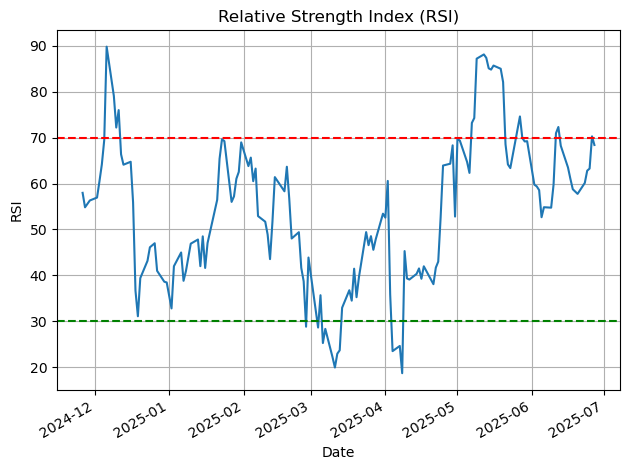

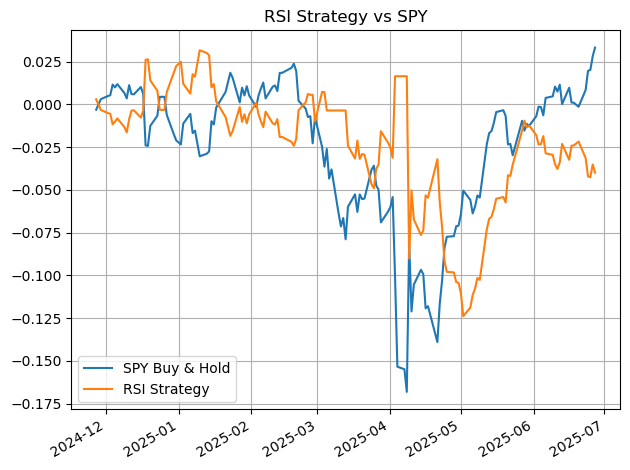

SPY Buy & Hold Return: 3.33%
158-Day RSI Strategy Return: -3.99%


Price,Close,High,Low,Open,Volume,RSI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,
2024-11-26,595.080566,595.754254,592.524472,593.247684,45621300,57.964555,-1,NaN,NaN
2024-11-27,593.277405,595.278633,591.741789,594.892296,34000200,54.811638,-1,-0.003030,0.003030
2024-11-29,596.962891,597.755461,593.822301,594.099673,30177400,56.300444,-1,0.003163,-0.003201
2024-12-02,598.032898,598.716502,596.883620,597.378984,31746000,56.935181,-1,0.004961,-0.004987
2024-12-03,598.310303,598.557985,596.754914,597.795165,26906600,60.453272,-1,0.005427,-0.005449
...,...,...,...,...,...,...,...,...,...
2025-06-23,600.150024,600.539978,591.890015,595.039978,87426000,60.120978,-1,0.008519,-0.031327
2025-06-24,606.780029,607.849976,603.409973,604.330017,67735300,62.793405,-1,0.019660,-0.042028
2025-06-25,607.119995,608.609985,605.539978,607.909973,62114800,63.257648,-1,0.020232,-0.042564


In [5]:
def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)
    return df

main()